In [1]:
import importlib
import terrain
import wind
import dynamics
#import visualization as vi

import numpy as np
importlib.reload(terrain)
importlib.reload(wind)
importlib.reload(dynamics)
#importlib.reload(vi)

# Ensure fresh module load
import sys
if 'era5vis.wind' in sys.modules:
    del sys.modules['era5vis.wind']
if 'era5vis.terrain' in sys.modules:
    del sys.modules['era5vis.terrain']
if 'era5vis.dynamics' in sys.modules:
    del sys.modules['era5vis.dynamics']

In [2]:
# Load terrain aspect dataset (pre-computed 1km)
terrain_ds = terrain.load_terrain_aspect_dataset()

terrain_ds['latitude'] = terrain_ds['latitude'].astype(np.float32)
terrain_ds['longitude'] = terrain_ds['longitude'].astype(np.float32)
terrain_ds['elevation'] = terrain_ds['elevation'].astype(np.int16)
terrain_ds['aspect_deg'] = terrain_ds['aspect_deg'].astype(np.int16)
terrain_ds['slope'] = terrain_ds['slope'].astype(np.int16)

terrain_ds


<xarray.Dataset> Size: 3MB
Dimensions:       (latitude: 232, longitude: 772)
Coordinates:
  * latitude      (latitude) float32 928B 48.0 47.99 47.97 ... 45.03 45.01 45.0
  * longitude     (longitude) float32 3kB 6.0 6.013 6.026 ... 15.97 15.99 16.0
Data variables:
    elevation     (latitude, longitude) int16 358kB 325 324 315 ... -1167 0
    aspect        (latitude, longitude) float64 1MB ...
    aspect_deg    (latitude, longitude) int16 358kB 23 25 13 334 ... 344 336 331
    slope         (latitude, longitude) int16 358kB 0 0 0 0 1 1 ... 13 13 12 9 7
    terrain_mask  (latitude, longitude) bool 179kB ...
Attributes:
    resolution_m:       990
    min_elevation:      500.0
    min_slope:          1.0
    description:        Terrain slope aspect dataset computed from SRTM data
    aspect_convention:  Downhill direction in radians, 0=North, π/2=East, ±π=...

In [4]:
##Example usage to add terrain intersection to ERA5 data
import xarray as xr
terrain_ds = terrain.load_terrain_aspect_dataset()
era5_path = "./data/era5_example_dataset.nc"
era5_path = "./data/ERA5testAlps.nc"
era5_path = "/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/data/ERA5testAlps.nc"
era5_path = "/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/era5vis-main/era5vis/data/andi.nc"
era5_data = xr.open_dataset(era5_path)

#Compress to save memory
era5_data['latitude'] = era5_data['latitude'].astype(np.float32)
era5_data['longitude'] = era5_data['longitude'].astype(np.float32)
era5_data['pressure_level'] = era5_data['pressure_level'].astype(np.int16)

era5_data['t'] = era5_data['t'].astype(np.float16)
era5_data['z'] = era5_data['z'].astype(np.uint16)
era5_data['u'] = era5_data['u'].astype(np.float16)
era5_data['v'] = era5_data['v'].astype(np.float16)


## add geopotential height to ds
era5_data['gph'] = dynamics.geopotential_height(era5_data['z'])



#
#  Crop ERA5 to terrain extent to reduce computation
crop = False
if crop:
    crop_lat_min, crop_lat_max = 46,47
    crop_lon_min, crop_lon_max = 15,15

    era5_data = era5_data.sel(
        latitude=slice(crop_lat_max, crop_lat_min),  
        longitude=slice(crop_lon_min, crop_lon_max)
)



era_lat_max, era_lat_min = era5_data.latitude.max(),era5_data.latitude.min()
era_lon_max, era_lon_min = era5_data.longitude.max(),era5_data.longitude.min()



terrain_ds = terrain_ds.sel(
    latitude=slice(era_lat_max, era_lat_min),  # ERA5 lats are decreasing
    longitude=slice(era_lon_min, era_lon_max)
)



# Interpolate ERA5 onto terrain grid
highres = True
if highres:
    era5_on_terrain = terrain.interpolate_to_grid(era5_data, terrain_ds)
    era5_with_terrain = terrain.compute_terrain_intersection(era5_on_terrain, terrain_ds)
else:
    era5_with_terrain = terrain.compute_terrain_intersection(era5_data, terrain_ds)

crop2 = False
if crop2:
    # Crop to Bolzano-Munich region (~30km width)
    # Bolzano: 46.5°N, 11.3°E
    # Munich: 48.1°N, 11.6°E
    # Region center: ~47.3°N, 11.45°E
    # ~30km = ~0.27° latitude, ~0.27° longitude (at this latitude)
    crop_lat_center = 47.3
    crop_lon_center = 11.45
    crop_width = 0.27

    era5_with_terrain = era5_with_terrain.sel(
        latitude=slice(crop_lat_center + crop_width, crop_lat_center - crop_width),
        longitude=slice(crop_lon_center - crop_width, crop_lon_center + crop_width)
    )

    print(f"Cropped to Bolzano-Munich region:")
    print(f"  Lat: [{crop_lat_center - crop_width:.2f}, {crop_lat_center + crop_width:.2f}]°N")
    print(f"  Lon: [{crop_lon_center - crop_width:.2f}, {crop_lon_center + crop_width:.2f}]°E")
    print(f"  Shape: {era5_with_terrain.dims}")

data = era5_with_terrain

## add theta
data['theta'] = dynamics.potential_temperature(data['t'], data['pressure_level'])


In [5]:
era5_data

<xarray.Dataset> Size: 91kB
Dimensions:         (valid_time: 1, pressure_level: 17, latitude: 13,
                     longitude: 41)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level  (pressure_level) int16 34B 1000 975 950 925 ... 550 500 450
  * latitude        (latitude) float32 52B 48.0 47.75 47.5 ... 45.5 45.25 45.0
  * longitude       (longitude) float32 164B 6.0 6.25 6.5 ... 15.5 15.75 16.0
    number          int64 8B ...
    expver          <U4 16B ...
Data variables:
    t               (valid_time, pressure_level, latitude, longitude) float16 18kB ...
    u               (valid_time, pressure_level, latitude, longitude) float16 18kB ...
    v               (valid_time, pressure_level, latitude, longitude) float16 18kB ...
    z               (valid_time, pressure_level, latitude, longitude) uint16 18kB ...
    gph             (valid_time, pressure_level, latitude, longitude) uint16 18kB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [9]:
def compress_era(dataset):
    dtype_map = {
        # coordinates / dimensions
        "latitude": np.float32,
        "longitude": np.float32,
        "pressure_level": np.int16,

        # data variables
        "t": np.float16,
        "u": np.float16,
        "v": np.float16,
        "z": np.uint16,
        "gph": np.uint16,  # derived from z if present
    }

    for var, dtype in dtype_map.items():
        if var in dataset:
            dataset[var] = dataset[var].astype(dtype)
    return data


In [10]:
era5_with_terrain = compress_era(era5_with_terrain)


era5_with_terrain

<xarray.Dataset> Size: 40MB
Dimensions:            (valid_time: 1, pressure_level: 17, latitude: 232,
                        longitude: 772)
Coordinates:
  * valid_time         (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level     (pressure_level) int16 34B 1000 975 950 ... 550 500 450
  * latitude           (latitude) float32 928B 48.0 47.99 47.97 ... 45.01 45.0
  * longitude          (longitude) float32 3kB 6.0 6.013 6.026 ... 15.99 16.0
    number             int64 8B ...
    expver             <U4 16B ...
Data variables:
    t                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    u                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    v                  (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    z                  (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    gph                (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    terrain            (valid_time, pressure_level, latitude, longitude) bool 3MB ...
    terrain_elevation  (latitude, longitude) int32 716kB 325 324 316 ... -1168 0
    theta              (valid_time, pressure_level, latitude, longitude) float16 6MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [8]:
# Step 2: Compute complete wind-terrain interaction (vectorized)
# Returns: wind_speed, wind_direction, downwind_terrain_height, perpendicular_wind_speed


era5_enhanced = wind.compute_wind_terrain_interaction(data, terrain_ds, range_km=3.0)


In [26]:
era5_enhanced

<xarray.Dataset> Size: 70MB
Dimensions:                   (valid_time: 1, pressure_level: 17,
                               latitude: 231, longitude: 772)
Coordinates:
  * valid_time                (valid_time) datetime64[ns] 8B 2025-09-02T12:00:00
  * pressure_level            (pressure_level) int16 34B 1000 975 ... 500 450
  * latitude                  (latitude) float32 924B 48.0 47.99 ... 45.03 45.01
  * longitude                 (longitude) float32 3kB 6.0 6.013 ... 15.99 16.0
    number                    int64 8B ...
    expver                    <U4 16B ...
Data variables:
    t                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    u                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    v                         (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    z                         (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    gph                       (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    terrain                   (valid_time, pressure_level, latitude, longitude) bool 3MB ...
    terrain_elevation         (latitude, longitude) int32 713kB 335 336 ... 0
    theta                     (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    wind_speed                (valid_time, pressure_level, latitude, longitude) float16 6MB ...
    wind_direction            (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    downwind_terrain_height   (valid_time, pressure_level, latitude, longitude) uint16 6MB ...
    perpendicular_wind_speed  (valid_time, pressure_level, latitude, longitude) float32 12MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2026-01-10T14:21 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
era5_enhancedNH = dynamics.compute_N_H(era5_enhanced)
era5_enhancedNH.perpendicular_wind_speed.max()


/media/afriesinger/Volume/Projekte/Gleitschirmfliegen/Studium/Programming/SciProFinal/.venv/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


<xarray.DataArray 'perpendicular_wind_speed' ()> Size: 4B
array(3.34, dtype=float32)
Coordinates:
    number   int64 8B ...
    expver   <U4 16B ...
Attributes:
    units:      m/s
    long_name:  Wind component perpendicular to terrain aspect

In [6]:
# Convert float16 variables to float32 for netCDF compatibility (netCDF doesn't support float16)
# This is only needed before saving to disk
era5_enhancedNH_save = era5_enhancedNH.copy()

# Convert theta from int16 to float32 (it was computed from float16 inputs)
if 'theta' in era5_enhancedNH_save.data_vars:
    era5_enhancedNH_save['theta'] = era5_enhancedNH_save['theta'].astype(np.float32)
    era5_enhancedNH_save['t'] = era5_enhancedNH_save['t'].astype(np.float32)
    era5_enhancedNH_save['u'] = era5_enhancedNH_save['u'].astype(np.float32)
    era5_enhancedNH_save['v'] = era5_enhancedNH_save['v'].astype(np.float32)
    era5_enhancedNH_save['wind_speed'] = era5_enhancedNH_save['wind_speed'].astype(np.float32)

print("Converted variables for netCDF compatibility:")
print(f"  theta: {era5_enhancedNH_save['theta'].dtype}")

era5_enhancedNH_save.to_netcdf('./data/era5_test_with_NH.nc')

Converted variables for netCDF compatibility:
  theta: float32


(array([601.,  40.,  18.,   4.,   8.,   3.,   2.,   0.,   0.,   1.]),
 array([  3.9789772 ,  93.35177612, 182.72457886, 272.09738159,
        361.47018433, 450.84298706, 540.21582031, 629.58862305,
        718.96142578, 808.33422852, 897.70703125]),
 <BarContainer object of 10 artists>)

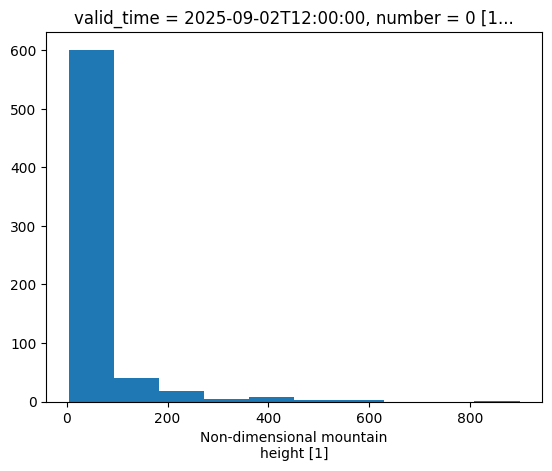

In [7]:
test  = era5_enhancedNH.H.where(era5_enhancedNH.H < 1000
                                )
test.mean()
test.plot()

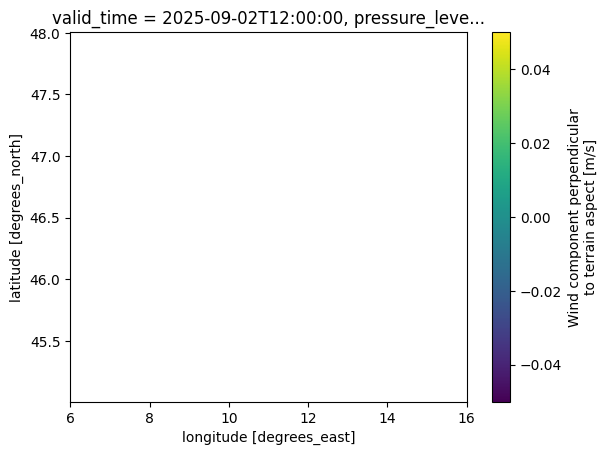

In [32]:

era5_enhancedNH.sel(
    pressure_level=900,

)['perpendicular_wind_speed'].plot()
#era5_enhancedNH



=== H Parameter Visualization ===



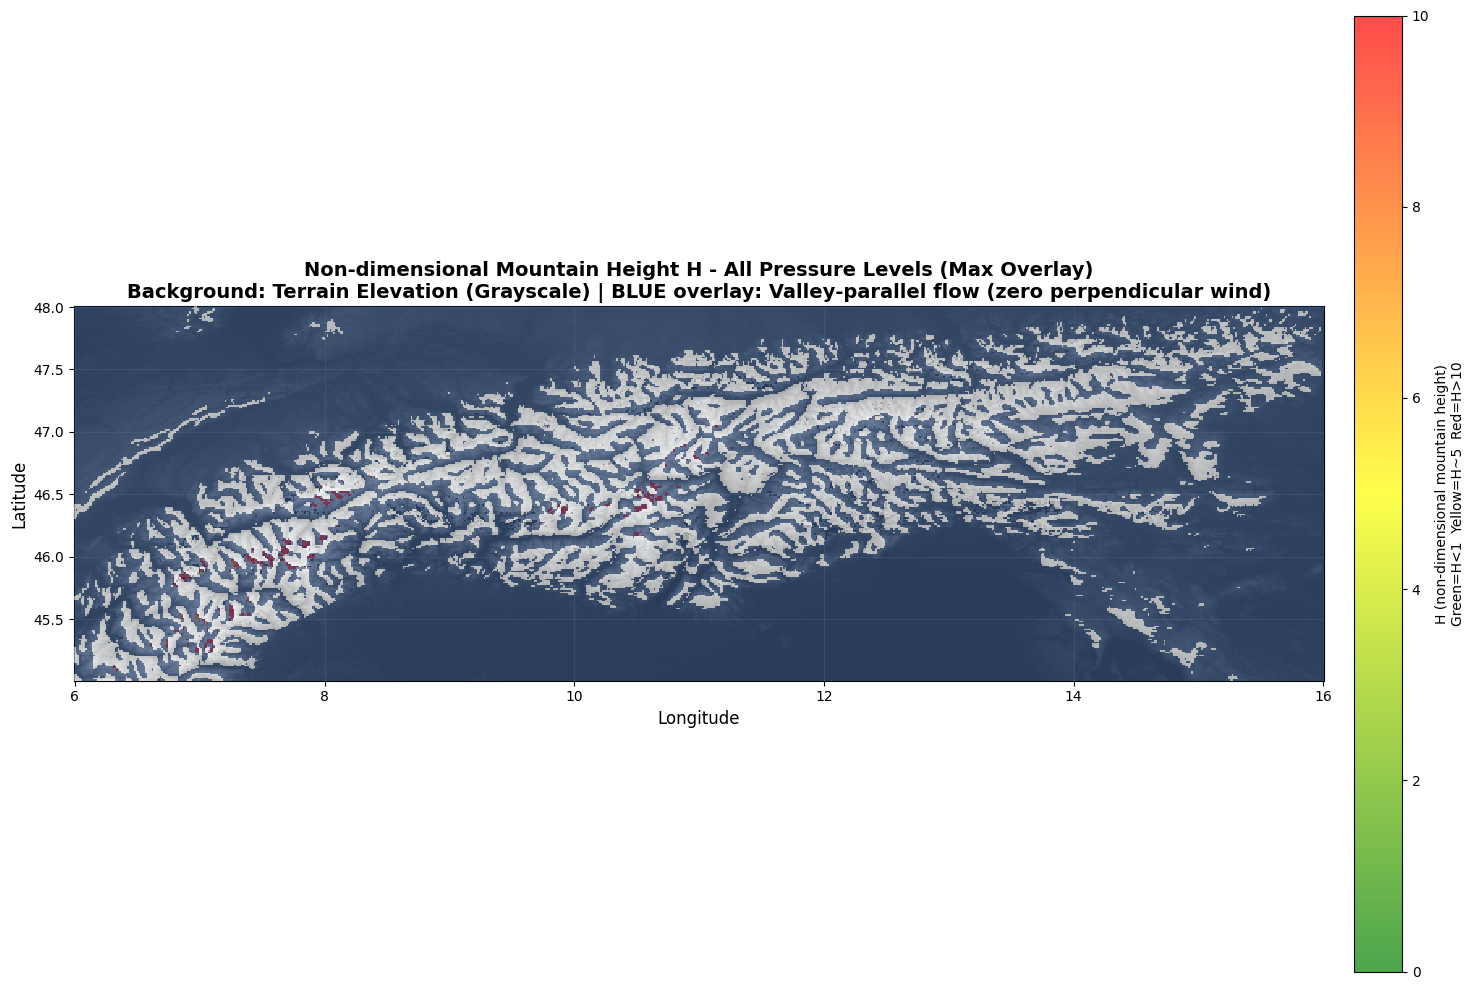

In [15]:
# Plot all pressure levels with blue overlay
print("=== H Parameter Visualization ===\n")

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# Flatten pressure dimension: take max H across all pressure levels
H_flattened = era5_enhancedNH['H'].isel(valid_time=0).max(dim='pressure_level')

# Check perpendicular wind speed - identify regions with zero cross-mountain flow
perp_wind_max = era5_enhancedNH['perpendicular_wind_speed'].isel(valid_time=0).max(dim='pressure_level')
zero_wind_mask = perp_wind_max == 0


# Filter: drop values > 100
H_filtered = H_flattened.where(H_flattened <= 100)


# Extract terrain elevation
terrain_elev = era5_enhancedNH['terrain_elevation']

# Create custom colormap: green (H < 1) -> yellow (H ~ 5) -> red (H > 10)
colors_h = ['green', 'yellow', 'red']
cmap_h = LinearSegmentedColormap.from_list('H_colormap', colors_h, N=256)

# Create figure
fig, ax = plt.subplots(figsize=(16, 10))

# Create meshgrid
lon_mesh = np.meshgrid(H_flattened.longitude.values, H_flattened.latitude.values)[0]
lat_mesh = np.meshgrid(H_flattened.longitude.values, H_flattened.latitude.values)[1]

# Plot terrain as background (grayscale, more prominent)
terrain_norm = (terrain_elev.values - terrain_elev.min().values) / (terrain_elev.max().values - terrain_elev.min().values)
ax.pcolormesh(lon_mesh, lat_mesh, terrain_norm, cmap='gray', shading='auto', alpha=0.7, zorder=1)

# Plot H values with custom green-yellow-red colormap (semi-transparent)
im_h = ax.pcolormesh(lon_mesh, lat_mesh, H_filtered.values, cmap=cmap_h, shading='auto', alpha=0.7, zorder=2, vmin=0, vmax=10)

# Overlay BLUE where perpendicular wind is zero (valley-parallel flow) - separate scale
blue_overlay = zero_wind_mask.values.astype(float)
ax.pcolormesh(lon_mesh, lat_mesh, blue_overlay, cmap='Blues_r', shading='auto', alpha=0.5, zorder=3, vmin=0, vmax=1)

# Colorbar for H
cbar = plt.colorbar(im_h, ax=ax, pad=0.02, label='H (non-dimensional mountain height)\nGreen=H<1  Yellow=H~5  Red=H>10')

# Labels
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title('Non-dimensional Mountain Height H - All Pressure Levels (Max Overlay)\nBackground: Terrain Elevation (Grayscale) | BLUE overlay: Valley-parallel flow (zero perpendicular wind)', 
             fontsize=14, fontweight='bold')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save figure
fig.savefig('H_parameter_all_levels_with_blue_overlay.png', dpi=300)


In [16]:
# Analyze memory consumption of era5_enhancedNH variables
import sys

def get_var_size_mb(var):
    """Get size of a variable in MB"""
    return sys.getsizeof(var) / (1024 ** 2)

# For xarray datasets, we can check memory more comprehensively
def analyze_dataset_memory(ds):
    """Analyze memory usage for all variables in an xarray Dataset"""
    print(f"\n{'Variable':<30} {'Shape':<40} {'Size (MB)':<15} {'dtype':<10}")
    print("=" * 95)
    
    total_mb = 0
    var_sizes = {}
    
    for var_name in sorted(ds.data_vars):
        var = ds[var_name]
        size_mb = var.nbytes / (1024 ** 2)
        var_sizes[var_name] = size_mb
        total_mb += size_mb
        shape_str = str(var.shape)
        print(f"{var_name:<30} {shape_str:<40} {size_mb:>10.2f} MB    {str(var.dtype):<10}")
    
    # Sort by size
    sorted_vars = sorted(var_sizes.items(), key=lambda x: x[1], reverse=True)
    
    print("\n" + "=" * 95)
    print(f"{'TOTAL':<30} {'':<40} {total_mb:>10.2f} MB")
    print("=" * 95)
    
    print("\n\nTOP MEMORY CONSUMERS:")
    print("-" * 50)
    for i, (var_name, size_mb) in enumerate(sorted_vars, 1):
        percentage = (size_mb / total_mb) * 100
        print(f"{i}. {var_name:<25} {size_mb:>10.2f} MB  ({percentage:>5.1f}%)")
    
    return var_sizes

# Analyze era5_enhancedNH
memory_usage = analyze_dataset_memory(era5_enhancedNH)


Variable                       Shape                                    Size (MB)       dtype     
H                              (1, 17, 231, 772)                             11.56 MB    float32   
N                              (1, 17, 231, 772)                             11.56 MB    float32   
downwind_terrain_height        (1, 17, 231, 772)                              5.78 MB    uint16    
gph                            (1, 17, 231, 772)                              5.78 MB    uint16    
perpendicular_wind_speed       (1, 17, 231, 772)                             11.56 MB    float32   
t                              (1, 17, 231, 772)                              5.78 MB    float16   
terrain                        (1, 17, 231, 772)                              2.89 MB    bool      
terrain_elevation              (231, 772)                                     0.68 MB    int32     
theta                          (1, 17, 231, 772)                              5.78 MB    float16   
